In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Question_Pairs_new/Question_Pairs_BiLSTM

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Question_Pairs_new/Question_Pairs_BiLSTM


In [2]:
# import dependencies
import torch
import torch.nn as nn
import torchtext
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
from datetime import datetime
device = "cuda:0" if torch.cuda.is_available() else "cpu"
!nvidia-smi

Wed Mar 17 08:01:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    25W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
question_1 = torchtext.legacy.data.Field(
    sequential = True,
    lower = True,
    batch_first = True,
    tokenize = 'spacy',
    pad_first = True,
    use_vocab = True
)

question_2 = torchtext.legacy.data.Field(
    sequential = True,
    lower = True,
    batch_first = True,
    tokenize = 'spacy',
    pad_first = True,
    use_vocab = True
)

label = torchtext.legacy.data.Field(
    sequential = False,
    use_vocab = False,
    is_target = True
)

In [4]:
dataset = torchtext.legacy.data.TabularDataset(
    path = 'dataset/train.csv', 
    format = 'csv',
    skip_header = True,
    fields = [
        (None, None),
        (None, None),
        (None, None),
        ('q1', question_1),
        ('q2', question_2),
        ('label', label)
        ] 
)

In [5]:
print(dataset[0].q1)
print(dataset[0].q2)
print(dataset[0].label)

['what', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market', 'in', 'india', '?']
['what', 'is', 'the', 'step', 'by', 'step', 'guide', 'to', 'invest', 'in', 'share', 'market', '?']
0


In [6]:
train_dataset, validation_dataset = dataset.split([0.8, 0.2], random_state = random.seed(42))

In [7]:
len(train_dataset), len(validation_dataset)

(323432, 80858)

In [8]:
question_1.build_vocab(train_dataset)
question_2.build_vocab(train_dataset)
question_1.vocab.extend(question_2.vocab)
question_2.vocab = question_1.vocab
vocab = question_1.vocab
len(vocab)
# vocab.stoi

87259

In [9]:
train_iter, valid_iter = torchtext.legacy.data.BucketIterator.splits(
    (train_dataset, validation_dataset), 
    sort_key = lambda x: len(x.q1)+len(x.q2),
    batch_sizes = (64,128),
    device = device
)

In [10]:
for inputs, labels in train_iter:
    print('questions_1: {}, shape: {}'.format(inputs[0], inputs[0].shape))
    print('questions_2: {}, shape: {}'.format(inputs[1], inputs[1].shape))
    print('lables: {}, shape: {}'.format(labels, labels.shape))
    break

questions_1: tensor([[   1,    1,    1,  ..., 3289, 4681,    2],
        [   1,    1,    1,  ..., 2161, 3199,    2],
        [   1,    1,    1,  ...,  934,   82,    2],
        ...,
        [   1,    1,    1,  ...,    7, 6059,    2],
        [   1,    1,    1,  ...,    9, 1097,    2],
        [   1,    1,    1,  ...,   38,   93,    2]], device='cuda:0'), shape: torch.Size([64, 51])
questions_2: tensor([[   1,    1,    1,  ..., 2148, 6172,    2],
        [   1,    1,    1,  ...,   56,  827,    2],
        [   7,  906,   86,  ...,   34,    6,    2],
        ...,
        [   1,    1,    1,  ..., 6059,  403,    2],
        [   1,    1,    1,  ...,    9, 1268,    2],
        [   1,    1,    1,  ...,   38,   93,    2]], device='cuda:0'), shape: torch.Size([64, 36])
lables: tensor([0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
        1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1], devic

In [11]:
for inputs, labels in valid_iter:
    print('questions_1: {}, shape: {}'.format(inputs[0], inputs[0].shape))
    print('questions_2: {}, shape: {}'.format(inputs[1], inputs[1].shape))
    print('lables: {}, shape: {}'.format(labels, labels.shape))
    break

questions_1: tensor([[    1,     1,     1,     4,     5, 81510,     2],
        [    1,     1,     1,     4,     5, 22218,     2],
        [    1,     1,     1,     4,    13, 11115,     2],
        [    1,     1,     1, 36511,     5,  1193,     2],
        [    1,     1,     1,     5, 61666,  2144,     2],
        [    1,     1,     1,     4,     5, 11284,     2],
        [    1,     1,     1,     5,  1433,  6958,     2],
        [    1,     1,     1,     4,     5,     0,     2],
        [    1,     1,     1, 11806,  1087,     0,     2],
        [    1,     1,     1,     5,     0,  8094,     2],
        [    1,     1,     1,     4,     5, 20887,     2],
        [    1,     1,     1,     5,     0,  5904,     2],
        [    1,     1,     1,     4,     5, 29016,     2],
        [    1,     1,     1,    24,    78,  3414,     2],
        [    1,     1,     1,     4,     5,     0,     2],
        [    1,     1,     1,     4,     5, 45185,     2],
        [    1,     1,     1,    24, 27346,

In [12]:
# itos
batch_train = next(iter(train_iter))
doc_train, label_train = batch_train
batch_test = next(iter(valid_iter))
doc_valid, label_valid = batch_test

def itos_(iterator):
    docs_ = []
    for i in range (len(iterator)):
        x = iterator[i].item()
        doc = str(question_1.vocab.itos[x])
        docs_.append(doc)
    docs = ' '.join(docs_)
    return docs, docs_

In [13]:
print(itos_(doc_train[0][4])[0])
print(itos_(doc_train[1][4])[0])
print('label: {}'.format(label_train[4]))

<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> what made tata group chairman cyrus mistry to quit ?
<pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> why cyrus mistry has been removed from tata group ?
label: 1


In [14]:
class BiLSTM(nn.Module):
    def __init__(self, n_vocabs, embed_dims, n_lstm_units, n_lstm_layers, n_output_classes):
        super(BiLSTM, self).__init__()
        self.v = n_vocabs
        self.e = embed_dims
        self.u = n_lstm_units
        self.l = n_lstm_layers
        self.o = n_output_classes

        self.embed = nn.Embedding(
            self.v,
            self.e
            )
        self.bilstm = nn.LSTM(
            input_size = self.e,
            hidden_size = self.u,
            num_layers = self.l,
            batch_first = True,
            bidirectional = True,
            dropout = 0.5
        )
        self.linear = nn.Linear(
            self.u * 4,
            self.o
        )

    def forward(self, X1, X2):
        h0 = torch.zeros(self.l * 2, X1.size(0), self.u).to(device)
        c0 = torch.zeros(self.l * 2, X1.size(0), self.u).to(device)
        out1 = self.embed(X1)
        out2 = self.embed(X2)
        # NxTxh, lxNxh
        out1, _ = self.bilstm(out1, (h0, c0))
        out2, _ = self.bilstm(out2, (h0, c0))
        out1 = out1[:, -1, :]
        out2 = out2[:, -1, :]
        # concatenate out1&2
        out = torch.cat((out1, out2), 1)
        out = self.linear(out)
        iout = torch.max(out, 1)[1]
        
        return iout, out

In [15]:
train_labels = torch.cat([i.label for i in train_iter])
negative = (train_labels == 0.).sum(dim=0).item()
positive = (train_labels == 1.).sum(dim=0).item()

In [16]:
print(f'number data in training set {len(train_dataset)}')
print(f'number of negative data in training set {negative}')
print(f'number of positive data in training set {positive}')

number data in training set 323432
number of negative data in training set 204011
number of positive data in training set 119421


class_weight :

n = 204011 * (119421 / 119421 + 204011)= 75327.1093491058

p = 119421 * (204011 / 119421 + 204011) = 75327.1093491058

In [17]:
torch.manual_seed(42)
model = BiLSTM(len(vocab), 512, 512, 2, 2).to(device)
class_weight = torch.tensor([positive/(positive+negative), negative/(positive+negative)]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weight, reduction='mean').to(device)
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr = 1e-4
    )

In [18]:
print(model)

BiLSTM(
  (embed): Embedding(87259, 512)
  (bilstm): LSTM(512, 512, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (linear): Linear(in_features=2048, out_features=2, bias=True)
)


In [19]:
import sys
num_epochs = 5
losses = []
accuracies  = []
val_losses = []
val_accuracies = []
val_loss_min = np.inf

for epoch in range(num_epochs):
    print('------------------------------------------------------------------------------------------')
    print('epoch: {}/{}:'.format(epoch + 1, num_epochs))   
    print('------------------------------------------------------------------------------------------')
    t0 = datetime.now()

    train_tqdm_bar = tqdm(enumerate(train_iter), total = (len(train_iter)), leave = False, position = 0, file = sys.stdout, dynamic_ncols = True)
    val_tqdm_bar = tqdm(enumerate(valid_iter), total = (len(valid_iter)),  leave = False, position = 0, file = sys.stdout, dynamic_ncols = True)

    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0

    model.train()
    for idx, (questions, labels) in train_tqdm_bar:
        iout, out = model(questions[0], questions[1])
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1)
        optimizer.step()
        running_loss += loss
        running_corrects += torch.sum(iout == labels)
        train_tqdm_bar.set_description(desc = 'train'.format(epoch + 1, num_epochs))
        batch_idx = (idx + 1) * 64

        train_tqdm_bar.set_postfix(
            loss = running_loss.item() / batch_idx if idx + 1 < len(train_iter) else running_loss.item() / len(train_iter.dataset)
            ,acc = running_corrects.item() / batch_idx if idx + 1 < len(train_iter) else running_corrects.item() / len(train_iter.dataset)
          )
    
    model.eval()
    with torch.no_grad():
        for val_idx, (v_questions, v_labels) in val_tqdm_bar:
            v_iout, v_out = model(v_questions[0], v_questions[1])
            v_loss = criterion(v_out, v_labels)
            val_running_loss += v_loss
            val_running_corrects += torch.sum(v_iout == v_labels)
            val_tqdm_bar.set_description('validate'.format(epoch + 1, num_epochs))
            val_batch_idx = (val_idx + 1) * 128

            val_tqdm_bar.set_postfix(
                val_loss = val_running_loss.item() / val_batch_idx if val_idx + 1 < len(valid_iter) else val_running_loss.item() / len(valid_iter.dataset)
                ,val_acc = val_running_corrects.item() / val_batch_idx if val_idx + 1 < len(valid_iter) else val_running_corrects.item() / len(valid_iter.dataset)
              )
    
    epoch_loss = running_loss/len(train_iter.dataset)
    losses.append(epoch_loss)
    epoch_accuracy = running_corrects/len(train_iter.dataset)
    accuracies.append(epoch_accuracy)
    val_epoch_loss = val_running_loss/len(valid_iter.dataset)
    val_losses.append(val_epoch_loss)
    val_epoch_accuracy = val_running_corrects/len(valid_iter.dataset)
    val_accuracies.append(val_epoch_accuracy)

    checkpoint = {
            'epoch': epoch + 1
            ,'state_dict': model.state_dict()
            ,'optimizer' : optimizer.state_dict()
            ,'val_loss_min' : val_epoch_loss
        }
    
    print('training loss: {:.4f}, acc: {:.2f}'.format(epoch_loss, epoch_accuracy))
    print('validation loss: {:.4f}, acc: {:.2f}'.format(val_epoch_loss, val_epoch_accuracy))
    print('elapsed time: {}'.format(str(datetime.now() - t0).split('.')[0]))

    if val_epoch_loss <= val_loss_min:
      print('validation loss decreased from {:.4f} to {:.4f}, saving model...'.format(val_loss_min, val_epoch_loss))
      torch.save(checkpoint, 'checkpoint/question_pairs_lowest_val_loss_epoch_{}.pth'.format(epoch + 1))
      val_loss_min = val_epoch_loss

------------------------------------------------------------------------------------------
epoch: 1/5:
------------------------------------------------------------------------------------------
training loss: 0.0087, acc: 0.71
validation loss: 0.0041, acc: 0.74
elapsed time: 0:07:53
validation loss decreased from inf to 0.0041, saving model...
------------------------------------------------------------------------------------------
epoch: 2/5:
------------------------------------------------------------------------------------------
training loss: 0.0079, acc: 0.76
validation loss: 0.0040, acc: 0.76
elapsed time: 0:07:57
validation loss decreased from 0.0041 to 0.0040, saving model...
------------------------------------------------------------------------------------------
epoch: 3/5:
------------------------------------------------------------------------------------------
training loss: 0.0072, acc: 0.78
validation loss: 0.0039, acc: 0.77
elapsed time: 0:08:00
validation loss decre

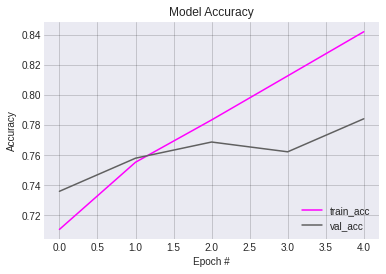

In [20]:
plt.style.use('seaborn-darkgrid')
plt.figure()
plt.plot(accuracies, color = 'magenta')
plt.plot(val_accuracies, color = '#606060')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch #')
plt.legend(['train_acc', 'val_acc'], loc = 'lower right')
plt.grid(axis = 'y', c = 'black', alpha = 0.2)
plt.grid(axis = 'x', c = 'black', alpha = 0.2)

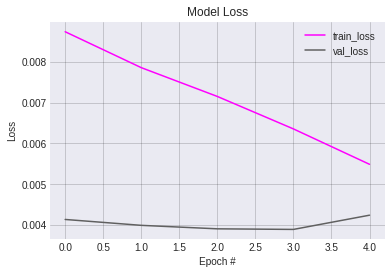

In [21]:
plt.figure()
plt.plot(losses, color = 'magenta')
plt.plot(val_losses, color = '#606060')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch #')
plt.legend(['train_loss', 'val_loss'], loc = 'upper right')
plt.grid(axis = 'y', c = 'black', alpha = 0.2)
plt.grid(axis = 'x', c = 'black', alpha = 0.2)